### Load libraries

In [1]:
# Systemic libraries
import os 
import sys
import tempfile
import warnings
from datetime import date

# Single-cell and data-wrangling 
import scanpy as sc 
import pandas as pd 
import numpy as np 
import numba as nb
import anndata as ad
import leidenalg
import scanpy.external as sce
import decoupler

# Visualization
import igraph as ig
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import sanbomics
from sanbomics.plots import volcano
import seaborn as sns

# DGE analysis
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

<i><b> Print the container version </b></i>

In [2]:
# Container used for this analysis can be found here : cokorac/cs-core-image-amd64:dev
day = date.today()
print('The last use of the container:', day)

The last use of the container: 2025-02-19


<i><b> Set the home directory </b></i>

In [3]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

### Load the data

In [4]:
# Load the individual datasets to extract sample_id information
adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad")

In [5]:
# Subset to classes of interest 
adata_ss = adata[adata.obs['FAM107A_and_HOPX_and_TNC_positive'].isin(['fam107a_and_hopx_and_tnc_positive'])]
adata_ss

View of AnnData object with n_obs × n_vars = 710 × 10801
    obs: 'sample_id', 'dataset_of_origin', 'leiden', 'FAM107A_and_HOPX_and_TNC_positive', 'HOPX_and_TNC_positive'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dataset_of_origin_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log_normalized_counts', 'log_normalized_scaled_counts', 'normalized_counts'
    obsp: 'connectivities', 'distances'

In [6]:
# Create the species column 
adata_ss.obs['species'] = ''
adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Ruan'] = 'mouse_Ncx'
adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Zylka'] = 'mouse_Ncx'
adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Linnarsson'] = 'mouse_DG'
adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Polioudakis'] = 'human_Ncx'
adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Trevino'] = 'human_Ncx'

/tmp/ipykernel_1558634/3194070177.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ss.obs['species'] = ''
/tmp/ipykernel_1558634/3194070177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Ruan'] = 'mouse_Ncx'
/tmp/ipykernel_1558634/3194070177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Zylka'] = 'mouse_Ncx'
/tmp/ipykernel_1558634/3194070177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

### DGE analysis

In [7]:
# Select raw counts
adata_ss.X = adata_ss.layers['counts'].copy()
# Round the raw counts
adata_ss.X = np.round(adata_ss.X)
# Print the raw counts layer
adata_ss.X

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [2., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
# Generate pseudobulk replicates
pdata = decoupler.get_pseudobulk(
    adata_ss,
    sample_col='sample_id',
    groups_col= ['species', 'dataset_of_origin'],
    layer='counts',
    mode= 'sum',
    min_cells=0,
    min_counts=0, 
)

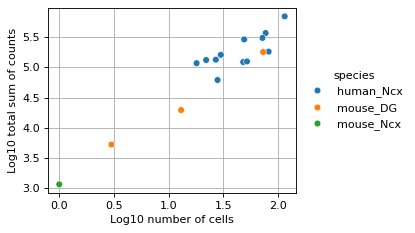

In [9]:
# Plot the pseudobulk replicates
decoupler.plot_psbulk_samples(pdata, groupby='species', figsize=(4, 3), dpi = 80)

In [10]:
# Re-generate pseudobulk replicates
pdata = decoupler.get_pseudobulk(
    adata_ss,
    sample_col='sample_id',
    groups_col= ['species', 'dataset_of_origin'],
    layer='counts',
    mode= 'sum',
    min_cells=3,
    min_counts=0, 
)

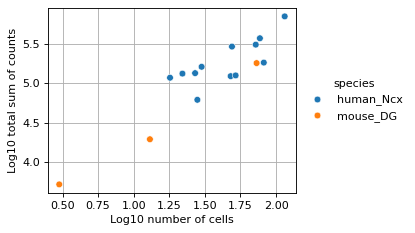

In [11]:
# Re-plot the pseudobulk replicates
decoupler.plot_psbulk_samples(pdata, groupby='species', figsize=(4, 3), dpi = 80)

In [12]:
# Subset to species of interest 
pdata_ss = pdata[pdata.obs['species'].isin(['human_Ncx', 'mouse_DG'])]
pdata_ss

View of AnnData object with n_obs × n_vars = 15 × 10715
    obs: 'sample_id', 'species_dataset_of_origin', 'dataset_of_origin', 'FAM107A_and_HOPX_and_TNC_positive', 'HOPX_and_TNC_positive', 'species', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    layers: 'psbulk_props'

In [13]:
# Switch to raw counts
pdata_ss.layers['counts'] = pdata_ss.X
pdata_ss.X = pdata_ss.layers['counts'].copy()

/tmp/ipykernel_1558634/3821636062.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  pdata_ss.layers['counts'] = pdata_ss.X


In [14]:
# Normalize, scale and compute pca
sc.pp.normalize_total(pdata_ss, target_sum=1e6, exclude_highly_expressed=True) #CPM
pdata_ss.layers['normalized'] = pdata_ss.X.copy()
sc.pp.log1p(pdata_ss)
pdata_ss.layers['log-normalized'] = pdata_ss.X.copy()
sc.pp.highly_variable_genes(pdata_ss, subset=False)
sc.pp.scale(pdata_ss, max_value=10)
pdata_ss.layers['log-normalized-scaled'] = pdata_ss.X.copy()

In [15]:
# Switch to normalized counts
pdata_ss.X = pdata_ss.layers['normalized'].copy()

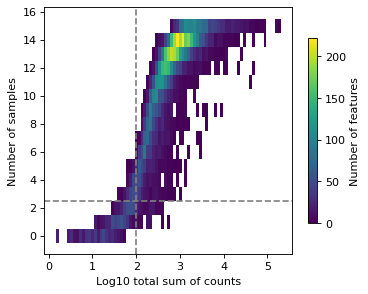

In [16]:
decoupler.plot_filter_by_expr(pdata_ss, group='species', min_count=10, min_total_count= 100, 
                              min_prop = 0.7, figsize = (5, 4), dpi = 80)

In [17]:
# Keep only sufficiently abundant genes
genes = decoupler.filter_by_expr(pdata_ss, group='species', min_count=10, min_total_count=100)
pdata_2 = pdata_ss[:, genes].copy()

In [18]:
# Switch back to raw counts
pdata_2.X = np.round(pdata_2.layers['counts']).astype(int).copy()
pdata_2.X

array([[ 8,  0,  4, ...,  4,  2,  8],
       [ 9,  4,  5, ...,  6,  0, 11],
       [ 5,  7,  5, ...,  4,  6, 13],
       ...,
       [ 0,  1,  0, ...,  0,  0,  1],
       [ 2,  6,  0, ...,  4,  7,  5],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [19]:
# Prepare the deseq2 format
dds_bRG_Ncx_DG = DeseqDataSet(
    adata = pdata_2,    
    design_factors= ['species'],
    ref_level=['species', 'human_Ncx'],
    refit_cooks=True)

/usr/local/lib/python3.10/dist-packages/pydeseq2/dds.py:270: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [20]:
# Run deseq2
dds_bRG_Ncx_DG.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.43 seconds.

Fitting dispersion trend curve...
... done in 0.20 seconds.

Fitting MAP dispersions...
... done in 2.52 seconds.

Fitting LFCs...
... done in 2.16 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 58 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.05 seconds.



In [21]:
# Extract the results
stat_res = DeseqStats(
    dds_bRG_Ncx_DG, 
    contrast=['species', 'human-Ncx', 'mouse-DG'])
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: species human-Ncx vs mouse-DG
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS     4.532463        1.930046  1.054806  1.829765  0.067285       NaN
AACS     2.905318       -0.578232  0.806370 -0.717080  0.473325       NaN
AADAT    2.288339        2.236367  1.542819  1.449534  0.147189       NaN
AAK1     6.353546        0.113556  0.780016  0.145581  0.884252  0.922715
AAMDC   10.794979       -1.105073  0.488445 -2.262433  0.023671  0.065587
...           ...             ...       ...       ...       ...       ...
ZXDC     2.341666        0.675512  1.143698  0.590639  0.554763       NaN
ZYG11B   9.183731        0.081529  0.557343  0.146282  0.883699  0.922715
ZYX      4.547052        1.341483  0.927070  1.447013  0.147893       NaN
ZZEF1    2.193645       -0.630676  0.954173 -0.660966  0.508634       NaN
ZZZ3     6.698824        1.012091  0.727254  1.391660  0.164025  0.268351

[9206 rows x 6 columns]


... done in 0.98 seconds.



In [22]:
# Save as dataframe
results_bRG_Ncx_DG = stat_res.results_df

In [23]:
# Reindex the dataframe
results_bRG_Ncx_DG_2 = results_bRG_Ncx_DG.copy()
results_bRG_Ncx_DG_2.reset_index(inplace=True)
results_bRG_Ncx_DG_2.rename(columns ={'index':'gene_name'}, inplace = True)

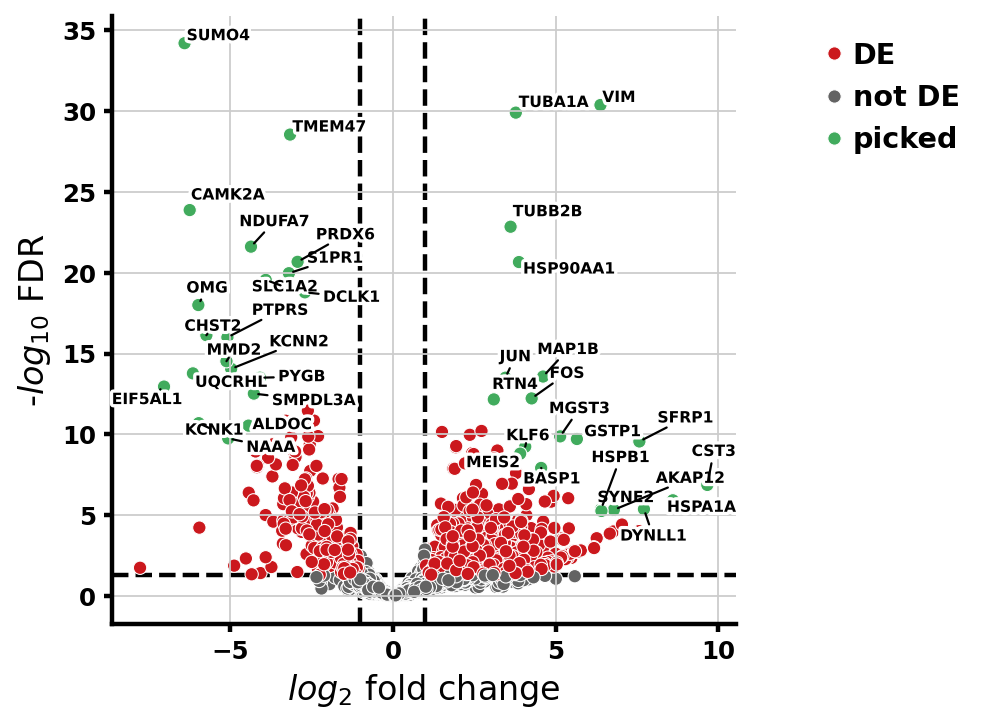

In [24]:
# Plot
sc.set_figure_params(dpi_save = 300, dpi = 80)
volcano(results_bRG_Ncx_DG_2, pvalue = 'padj', log2fc = 'log2FoldChange', symbol = 'gene_name', 
        pval_thresh = 0.05, to_label = 20, fontsize = 7, log2fc_thresh = 1, colors = ['#cb181d', '#636363', '#41ab5d'], save = '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/degs/hNCX_mDG_degs')

In [25]:
DEGs = results_bRG_Ncx_DG_2[results_bRG_Ncx_DG_2['padj'] < 0.05]

degs_up = DEGs[DEGs['log2FoldChange'] > 1]
degs_down = DEGs[DEGs['log2FoldChange'] < -1]

In [26]:
print(len(degs_up))
print(len(degs_down))

1089
337
